In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
from customized import preprocess
from customized import metrics
from customized.model import rnns

### Read data

In [2]:
prod = pd.read_pickle('data/prod.pkl')
txn = pd.read_pickle('data/txn.pkl')
cmt = pd.read_pickle('data/cmt.pkl')
sub_txn = txn[txn.user_id.isin(['10891','12235','6112','6835','6897','4460','4793'])]
sub_txn.user_id.value_counts()
streamer_static_fname='streamer_static_features_7.csv'
end_date = '2021-11-01' # 半年 # 下一場次是2021-11-02

# Customer-Streamer Model

In [3]:
rfm, static_df = preprocess.generate_static_user_context(sub_txn, end_date)
streamer = preprocess.generate_streamer_features(streamer_static_fname, sub_txn, prod, cmt, rfm, end_date) # 製作streamer features
scale_streamer = preprocess.standardize(streamer)     # 標準化
t = 5
txn_n = preprocess.generate_last_n_txn(sub_txn, t, end_date)        # 找出最後n次交易
s_seq = preprocess.generate_streamer_seq(txn_n, scale_streamer, t)  # input sequences
labels_k = dict(zip(streamer.index.to_list(), [i for i in range(streamer.shape[0])])) # user_id as key
s_labels = preprocess.generate_streamer_targets(txn_n, labels_k) # label sequences' targets
print(s_seq.shape, s_labels.shape)

付款單號不等於t筆: 0
(37442, 115) (37442,)


In [4]:
batch_size = 32

x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(s_seq, s_labels, test_size=0.33, random_state=2022) # split data
train_dataset = preprocess.StreamerDataset(x_s_train, y_s_train)
test_dataset = preprocess.StreamerDataset(x_s_test, y_s_test)

# Load data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True) # 訓練模型時打亂順序
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False) # 測試集不需要打亂結果也是一樣(因為沒有訓練，是拿已訓練完畢的模型直接產出結果)

### RNN/LSTM/GRU models for Classfication

In [5]:
def policy_generation(algo):

    if  algo == 'GRU':
        policy = rnns.GRU(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'BiGRU':
        policy = rnns.BiGRU(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'BayesGRU':
        policy = rnns.BayesGRU(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'RNN':
        policy = rnns.RNN(input_size, hidden_size, num_layers, num_classes).to(device)
    elif algo == 'BiRNN':
        policy = rnns.BiRNN(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'BayesRNN':
        policy = rnns.BayesRNN(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'LSTM':
        policy = rnns.LSTM(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'BiLSTM':
        policy = rnns.BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
    elif algo == 'BayesLSTM':
        policy = rnns.BayesLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
    return policy

GRU
Testing Accuracy: 94.3105 %
GRU loss : 0.352
BiGRU
Testing Accuracy: 94.3266 %
BiGRU loss : 0.18
BayesGRU
Testing Accuracy: 94.2700 %
BayesGRU loss : 0.2907
RNN
Testing Accuracy: 94.2700 %
RNN loss : 0.0291
BiRNN
Testing Accuracy: 94.2457 %
BiRNN loss : 0.2411
BayesRNN
Testing Accuracy: 94.0838 %
BayesRNN loss : 0.0251
LSTM
Testing Accuracy: 94.1000 %
LSTM loss : 0.2391
BiLSTM
Testing Accuracy: 94.4238 %
BiLSTM loss : 0.0783
BayesLSTM
Testing Accuracy: 94.2052 %
BayesLSTM loss : 0.0213


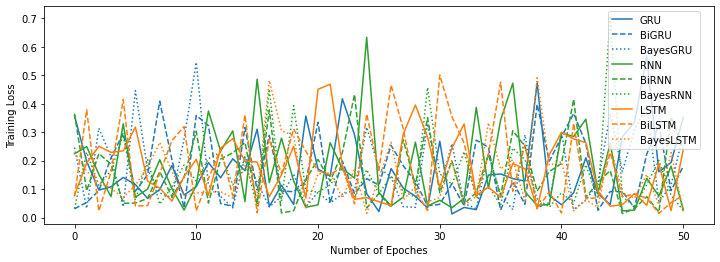

In [7]:
loss_record = {}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
end_date = '2021-11-01'
num_classes = streamer.shape[0]
input_size = streamer.shape[1]
num_epochs = 51
learning_rate = 0.001
hidden_size = 128
num_layers = 1
sequence_length = t
algo_list = ['GRU','BiGRU','BayesGRU','RNN','BiRNN','BayesRNN','LSTM','BiLSTM','BayesLSTM']
col = sorted(['#1f77b4','#ff7f0e','#2ca02c'] * 3)
linestyle = ['-','--',':']*3
c = 0
plt.figure(figsize=(12,4))

for algo in algo_list:
    print(algo)
    if algo not in loss_record:
        loss_record[algo] = []
        
    model = policy_generation(algo)

    # Loss and optimizer
    loss_funtion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    # Train the model
    n_total_steps = len(train_loader) # total sample/N 批次
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader): 
            
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, hn = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
            loss = loss_funtion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % n_total_steps == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        loss_record[algo].append(loss.item())

    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs, hn = model(inputs)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Testing Accuracy: {acc:.4f} %') # 72~87

        
    # plot            
    print(algo,"loss :", round(loss_record[algo][-1],4))
    plt.plot(range(len(loss_record[algo])), loss_record[algo], c=col[c], ls=linestyle[c], label=algo)
    plt.ylabel('Training Loss')
    plt.xlabel('Number of Epoches')
    plt.legend(labels=algo_list, bbox_to_anchor=(.98, .98), loc=1, borderaxespad=0.)
    plt.legend(labels=algo_list, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    # plt.gca().set_ylim([0, 1])
    c += 1
plt.savefig(fname='./fig/loss_cs_rnns.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

GRU loss : 0.021
BiGRU loss : 0.1141
BayesGRU loss : 0.1744
RNN loss : 0.0884
BiRNN loss : 0.0846
BayesRNN loss : 0.084
LSTM loss : 0.0557
BiLSTM loss : 0.1658
BayesLSTM loss : 0.1373


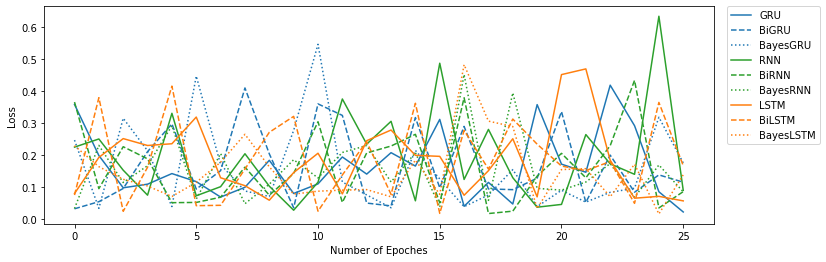

In [12]:
# revised plot
plt.figure(figsize=(12,4))
c=0
for algo in algo_list:
    print(algo,"loss :", round(loss_record[algo][25],4))
    plt.plot(range(len(loss_record[algo][:26])), loss_record[algo][:26], c=col[c], ls=linestyle[c], label=algo)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoches')
    plt.legend(labels=algo_list, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    c += 1
plt.savefig(fname='./fig/loss_cs_rnns.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

# Customer-Product Model

In [33]:
batch_size = 32
t = 10

### preprocess streamer data ###
prod_n = preprocess.generate_last_n_prod(sub_txn, t, end_date)        # 找出最後n次交易
basket_seq_prods, basket_tar_prods = preprocess.generate_basket_list(prod_n, t)
basket_seq_emb = preprocess.cal_basket_embedding(basket_seq_prods)
basket_tar_emb = preprocess.cal_basket_embedding(basket_tar_prods)
print(basket_seq_emb.shape, basket_tar_emb.shape)
### preprocess streamer data ###

x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(basket_seq_emb, basket_tar_emb, test_size=0.33, random_state=2022) # split data
print(x_s_train.shape, x_s_test.shape, y_s_train.shape, y_s_test.shape)

# Read & transform data
train_dataset = preprocess.BasketDataset(x_s_train, y_s_train)
test_dataset = preprocess.BasketDataset(x_s_test, y_s_test)

# Load data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)

付款單號不等於t筆: 0
(43954, 3840) (43954, 768)
(29449, 3840) (14505, 3840) (29449, 768) (14505, 768)


GRU
Start training...
Epoch [10/50], Step [921/921], Loss: 0.0092
Epoch [20/50], Step [921/921], Loss: 0.0054
Epoch [30/50], Step [921/921], Loss: 0.0077
Epoch [40/50], Step [921/921], Loss: 0.0073
Epoch [50/50], Step [921/921], Loss: 0.0048
[Test] Step [454/454], Loss: 0.0090
GRU loss : 0.0048
BayesGRU
Start training...
Epoch [10/50], Step [921/921], Loss: 0.0078
Epoch [20/50], Step [921/921], Loss: 0.0063
Epoch [30/50], Step [921/921], Loss: 0.0086
Epoch [40/50], Step [921/921], Loss: 0.0056
Epoch [50/50], Step [921/921], Loss: 0.0036
[Test] Step [454/454], Loss: 0.0093
BayesGRU loss : 0.0036
RNN
Start training...
Epoch [10/50], Step [921/921], Loss: 0.0106
Epoch [20/50], Step [921/921], Loss: 0.0085
Epoch [30/50], Step [921/921], Loss: 0.0068
Epoch [40/50], Step [921/921], Loss: 0.0077
Epoch [50/50], Step [921/921], Loss: 0.0087
[Test] Step [454/454], Loss: 0.0085
RNN loss : 0.0087
BayesRNN
Start training...
Epoch [10/50], Step [921/921], Loss: 0.0149
Epoch [20/50], Step [921/921], 

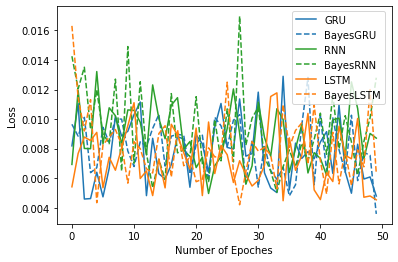

In [60]:
cp_loss_record = {}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 125 # 25 dim x t seq x 1
num_epochs = 50
learning_rate = 0.001
hidden_size = 256
num_layers = 1
sequence_length = t
input_size = int(basket_seq_emb.shape[1]/t) # 768
num_classes = basket_tar_emb.shape[1] # 768
col = sorted(['#1f77b4','#ff7f0e','#2ca02c'] * 2)
linestyle = ['-','--']*3
c = 0

for algo in algo_list:
    print(algo)
    if algo not in cp_loss_record:
        cp_loss_record[algo] = []
        
    cp_model = policy_generation(algo)

    # Loss and optimizer
    loss_funtion = nn.MSELoss() # Regression
#     loss_funtion = nn.BCEWithLogitsLoss() # BCE + sigmoid
    optimizer = torch.optim.Adam(cp_model.parameters(), lr=learning_rate) 

    # Train the model
    n_total_steps = len(train_loader) # total sample/N 批次
    
    print("Start training...")
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(train_loader): # 不是labels而是targets
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs, hn = cp_model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
            loss = loss_funtion(outputs, targets)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (((i+1) % n_total_steps == 0) & ((epoch+1) % 10 == 0)):
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        cp_loss_record[algo].append(loss.item())
        
    # Test the model
    n_total_steps = len(test_loader) # total sample/N 批次
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            targets = targets.to(device)
            outputs, hn = cp_model(inputs)
            loss = loss_funtion(outputs, targets)
            if (i+1) % n_total_steps == 0:
                print (f'[Test] Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    print(algo,"loss :", round(cp_loss_record[algo][-1],4))
    plt.plot(range(len(cp_loss_record[algo])), cp_loss_record[algo], c=col[c], ls=linestyle[c], label=algo)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoches')
    plt.legend(labels=algo_list, bbox_to_anchor=(.98, .98), loc=1, borderaxespad=0.)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    c += 1
plt.savefig(fname='./fig/loss_cp_rnns.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

GRU loss : 0.0159
BayesGRU loss : 0.2215
RNN loss : 0.0671
BayesRNN loss : 0.3706
LSTM loss : 0.1061
BayesLSTM loss : 0.013
GRU loss : 0.0048
BayesGRU loss : 0.0036
RNN loss : 0.0087
BayesRNN loss : 0.0128
LSTM loss : 0.0045
BayesLSTM loss : 0.0063


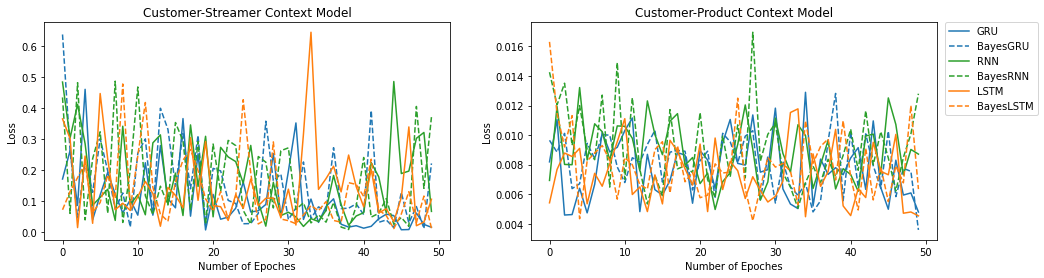

In [76]:
# revised plot
col = sorted(['#1f77b4','#ff7f0e','#2ca02c'] * 2)
linestyle = ['-','--']*3
c = 0
plt.figure(figsize=(16,4))
plt.subplot(121) # need plt.figure() first, so do for-loop twice
for algo in algo_list:
    print(algo,"loss :", round(cs_loss_record[algo][-1],4))
    plt.plot(range(len(cs_loss_record[algo])), cs_loss_record[algo], c=col[c], ls=linestyle[c], label=algo)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoches')
    plt.title('Customer-Streamer Context Model')
    c += 1
c = 0
plt.subplot(122)
for algo in algo_list:
    print(algo,"loss :", round(cp_loss_record[algo][-1],4))
    plt.plot(range(len(cp_loss_record[algo])), cp_loss_record[algo], c=col[c], ls=linestyle[c], label=algo)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoches')
    plt.title('Customer-Product Context Model')
    plt.legend(labels=algo_list, bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0.)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    c += 1
plt.savefig(fname='./fig/loss_rnns.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()